**"Predict the train ticket price"**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
# la otra forma, pero lo mismo: from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("train_set.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19452 entries, 0 to 19451
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   origin             19452 non-null  object 
 1   destination        19452 non-null  object 
 2   train_type         19452 non-null  object 
 3   train_class        19452 non-null  object 
 4   fare               19452 non-null  object 
 5   start_date_hour    19452 non-null  int64  
 6   start_date_minute  19452 non-null  int64  
 7   end_date_hour      19452 non-null  int64  
 8   end_date_minute    19452 non-null  int64  
 9   date_day           19452 non-null  int64  
 10  price              19452 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 1.6+ MB


In [4]:
df.head()

,origin,destination,train_type,train_class,fare,start_date_hour,start_date_minute,end_date_hour,end_date_minute,date_day,price
0,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,8,45,9,50,1,31.1
1,MADRID,ZARAGOZA,AVE,Turista,Promo,11,30,12,51,4,44.0
2,MADRID,ZARAGOZA,AVE,Turista,Flexible,8,20,9,35,2,55.7
3,MADRID,TARRAGONA,AVE,Turista,Flexible,7,30,10,3,2,82.6
4,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,20,35,21,40,4,31.1


La hora de salida de los trenes está indicada por dos columnas, la de la hora y la de los minutos. La voy a unificar en una columna donde la hora este indicada en formato decimal (el lugar de sexagesimal), que llamaré 'hour_star_decimal'. Con la hora de llegada actuaré de igual manera y se llamará 'hour_end_decimal'.

In [4]:
df['hour_star_decimal'] = df['start_date_hour'] + round(df['start_date_minute']/60, 4)
df['hour_star_decimal']
df['hour_end_decimal'] = df['end_date_hour'] + round(df['end_date_minute']/60, 4)
df['hour_end_decimal']

0         9.8333
1        12.8500
2         9.5833
3        10.0500
4        21.6667
          ...   
19447     9.2500
19448    11.9500
19449    17.7500
19450    13.1667
19451    21.6667
Name: hour_end_decimal, Length: 19452, dtype: float64

In [7]:
df.head()

,origin,destination,train_type,train_class,fare,start_date_hour,start_date_minute,end_date_hour,end_date_minute,date_day,price,hour_star_decimal,hour_end_decimal
0,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,8,45,9,50,1,31.1,8.7500,9.8333
1,MADRID,ZARAGOZA,AVE,Turista,Promo,11,30,12,51,4,44.0,11.5000,12.8500
2,MADRID,ZARAGOZA,AVE,Turista,Flexible,8,20,9,35,2,55.7,8.3333,9.5833
3,MADRID,TARRAGONA,AVE,Turista,Flexible,7,30,10,3,2,82.6,7.5000,10.0500
4,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,20,35,21,40,4,31.1,20.5833,21.6667


In [5]:
dfX = df.drop(['start_date_hour', 'start_date_minute','end_date_hour','end_date_minute','price'], axis=1)
dfX.head()

,origin,destination,train_type,train_class,fare,date_day,hour_star_decimal,hour_end_decimal
0,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,1,8.7500,9.8333
1,MADRID,ZARAGOZA,AVE,Turista,Promo,4,11.5000,12.8500
2,MADRID,ZARAGOZA,AVE,Turista,Flexible,2,8.3333,9.5833
3,MADRID,TARRAGONA,AVE,Turista,Flexible,2,7.5000,10.0500
4,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,4,20.5833,21.6667


In [6]:
# Aplico Encode a las columnas categóricas.
df_categorical_no_numbers = dfX[dfX.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)
df_categorical_no_numbers.head()

,origin,destination,train_type,train_class,fare
0,3,1,1,1,0
1,1,4,2,1,3
2,1,4,2,1,2
3,1,2,2,1,2
4,3,1,1,1,0


In [7]:
#El resto de las columnas será
df_others = dfX.select_dtypes(exclude=['object'])
df_others.head()

,date_day,hour_star_decimal,hour_end_decimal
0,1,8.7500,9.8333
1,4,11.5000,12.8500
2,2,8.3333,9.5833
3,2,7.5000,10.0500
4,4,20.5833,21.6667


In [ ]:
# Aplico normalización a las columnas numericas que están en el df_others
#from sklearn.preprocessing import MinMaxScaler

# Por el momento no lo voy a aplicar

#scaler = MinMaxScaler()
#df_others_normalized = pd.DataFrame(
#    data=scaler.fit_transform(df_others.values), 
#    columns=df_others.columns, 
#    index=df_others.index)

In [8]:
# Dataframe con valores categoricos encode más valores numéricos.
df1 = pd.concat([df_categorical_no_numbers,df_others], axis=1)
df1

,origin,destination,train_type,train_class,fare,date_day,hour_star_decimal,hour_end_decimal
0,3,1,1,1,0,1,8.7500,9.8333
1,1,4,2,1,3,4,11.5000,12.8500
2,1,4,2,1,2,2,8.3333,9.5833
3,1,2,2,1,2,2,7.5000,10.0500
4,3,1,1,1,0,4,20.5833,21.6667
...,...,...,...,...,...,...,...,...
19447,4,1,2,1,3,1,7.8000,9.2500
19448,1,2,2,1,2,3,9.5000,11.9500
19449,1,4,2,1,2,4,16.5000,17.7500
19450,2,1,2,1,2,1,10.5500,13.1667


In [ ]:
1. Definir X e y

In [9]:
X = df1.values
y = df.price.values

In [10]:
X.shape

(19452, 8)

In [11]:
y.shape

(19452,)

Aplico la reduccion de dimensionalidad con el método TSNE y lo paso a dos dimensiones

In [12]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(19452, 2)

In [11]:
df_graf = pd.concat([df1, df['price']], axis=1)

In [ ]:
sns.pairplot(df_graf) 

<AxesSubplot:>

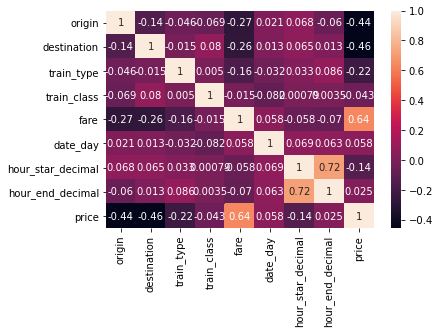

In [13]:
# Muestro la matriz de correlación
sns.heatmap(df_graf.corr(), annot = True)

#### 2. Dividir X_train, X_test, y_train, y_test

In [13]:
# Divido la muestra
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.20, random_state=7)

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [15]:
k_fold = RepeatedKFold(n_splits=20, n_repeats=1, random_state=1)
val_score = []
train_score = []
# define the model
model_RFR = RandomForestRegressor(n_estimators=130, random_state=1, warm_start=True)

for i, (train, val) in enumerate(k_fold.split(X_train)):
    print("Iteración:", i+1)
    print("train/índices batch:", train)
    print("batch_size:", len(train))
    print("val:", val)
    print("val_size:", len(val))
    print("batch:", X_train[train])
    # train the model
    model_RFR.fit(X_train[train], y_train[train]) # Aquí estoy entrenando con cross validation pq entreno cachito a cachito y me va a dar mejor score
    score_val = model_RFR.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model_RFR.score(X_train[train], y_train[train])
    train_score.append(score_train)

13   124   132   148   173   182
   189   193   198   199   208   257   258   261   319   336   339   350
   369   371   375   400   409   425   429   441   463   491   493   514
   523   578   585   590   640   653   692   708   722   737   742   743
   760   782   807   809   828   873   877   886   935   937   948   969
   972   992   999  1001  1053  1057  1058  1068  1069  1076  1118  1136
  1157  1188  1192  1199  1205  1210  1223  1226  1257  1285  1294  1339
  1353  1363  1440  1445  1464  1469  1471  1496  1517  1575  1588  1593
  1605  1611  1623  1640  1659  1663  1695  1696  1706  1713  1778  1805
  1816  1846  1870  1908  1920  1948  1952  1957  1965  2026  2059  2062
  2071  2110  2111  2121  2125  2152  2163  2170  2211  2238  2259  2260
  2269  2283  2299  2301  2306  2317  2323  2329  2368  2380  2386  2396
  2449  2466  2494  2496  2511  2607  2609  2614  2642  2662  2686  2693
  2715  2716  2725  2771  2786  2798  2826  2830  2891  2892  2898  2952
  2960  3007  3020

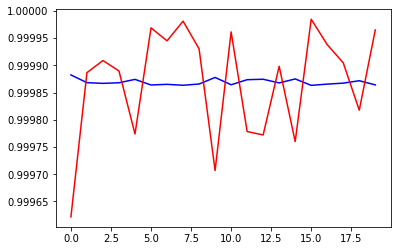

In [16]:
plt.plot(train_score, color="b")
plt.plot(val_score, color="r")

In [17]:
score_RFR_KFold = model_RFR.score(X_test, y_test)
score_RFR_KFold 

0.9996246739483912

In [18]:
y_pred = model_RFR.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 0.5090415538441855


NO CONTINUO PORQUE EL RMSE OBTENIDO ES MAS ALTO QUE EL OBTENIDO SOLAMENTE HACIENDO RandomForest SIN REDUCCION DE DIMENSIONALIDAD

In [ ]:
# Create a pipeline

# Le podemos poner cualquier clasificador. Irá cambiando según va probando pero necesita 1.
pipe = Pipeline(steps=[('classifier', RandomForestRegressor())])


logistic_params = {
    'classifier': [LogisticRegression()],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(0, 4, 10)
    }

random_forest_params = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_features': [1, 2, 3]
    }

svm_params = {
    'classifier': [svm.SVC()],
    'classifier__kernel':('linear', 'rbf', 'sigmoid'), 
    'classifier__C':[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
    'classifier__degree': to_test,
    'classifier__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
    'classifier__gamma': ('scale', 'auto')
    }


# Create space of candidate learning algorithms and their hyperparameters
search_space = [
    logistic_params,
    random_forest_params,
    #svm_params
    ]

In [ ]:
%%time

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# Create grid search 
clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=cv, verbose=10, n_jobs=-1)

# Fit grid search
best_model = clf.fit(X_train_grid, y_train_grid)
# View best model
separator = "\n############################\n"
print(separator)
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print(separator)
print("clf.best_params_", clf.best_params_)
print(separator)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'finished_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

#### 3. Asignar el modelo a una variable
Aquí se pondrían los parámetros

#### 4. Entrenar el modelo con X_train, y_train

5. Predecir con el modelo ya entrenado con X_test/to_pred

## Una vez listo el modelo, toca predecir con el dataset de predicción 

In [35]:
to_pred = pd.read_csv("test_set.csv")

In [36]:
# IMPORTANTE: APLICAR LO MISMO A ESTOS DATOS QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO
# SI EL ARRAY CON EL QUE HICISTEIS .fit() ERA DE 4 COLUMNAS, PARA .predict() DEBEN SER LAS MISMAS
# SI AL ARRAY CON EL QUE HICISTEIS .fit() LO NORMALIZASTEIS, PARA .predict() DEBÉIS NORMALIZARLO
# TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 133744 FILAS
# SI O SI

to_pred.head()

,origin,destination,train_type,train_class,fare,start_date_hour,start_date_minute,end_date_hour,end_date_minute,date_day
0,BARCELONA,MADRID,AVE,Turista,Promo,18,25,20,55,2
1,BARCELONA,MADRID,AVE,Turista,Promo +,14,0,17,10,5
2,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,14,10,15,15,3
3,MADRID,ZARAGOZA,AVE,Turista,Promo,20,45,22,6,1
4,MADRID,BARCELONA,AVE,Turista,Promo,18,30,21,20,4


In [37]:
#Cambio las columnas de las horas y su formato
to_pred['hour_star_decimal'] = to_pred['start_date_hour'] + round(to_pred['start_date_minute']/60, 4)
to_pred['hour_star_decimal']
to_pred['hour_end_decimal'] = to_pred['end_date_hour'] + round(to_pred['end_date_minute']/60, 4)
to_pred.head()

,origin,destination,train_type,train_class,fare,start_date_hour,start_date_minute,end_date_hour,end_date_minute,date_day,hour_star_decimal,hour_end_decimal
0,BARCELONA,MADRID,AVE,Turista,Promo,18,25,20,55,2,18.4167,20.9167
1,BARCELONA,MADRID,AVE,Turista,Promo +,14,0,17,10,5,14.0000,17.1667
2,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,14,10,15,15,3,14.1667,15.2500
3,MADRID,ZARAGOZA,AVE,Turista,Promo,20,45,22,6,1,20.7500,22.1000
4,MADRID,BARCELONA,AVE,Turista,Promo,18,30,21,20,4,18.5000,21.3333


In [38]:
to_predX = to_pred.drop(['start_date_hour', 'start_date_minute','end_date_hour','end_date_minute'], axis=1)
to_predX.head()

,origin,destination,train_type,train_class,fare,date_day,hour_star_decimal,hour_end_decimal
0,BARCELONA,MADRID,AVE,Turista,Promo,2,18.4167,20.9167
1,BARCELONA,MADRID,AVE,Turista,Promo +,5,14.0000,17.1667
2,VALLADOLID,MADRID,AVANT,Turista,Adulto ida,3,14.1667,15.2500
3,MADRID,ZARAGOZA,AVE,Turista,Promo,1,20.7500,22.1000
4,MADRID,BARCELONA,AVE,Turista,Promo,4,18.5000,21.3333


In [39]:
# Aplico Encode a las columnas categóricas.
to_pred_categorical_no_numbers = to_predX[to_predX.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)
to_pred_categorical_no_numbers.head()

,origin,destination,train_type,train_class,fare
0,0,1,2,1,3
1,0,1,2,1,4
2,3,1,1,1,0
3,1,4,2,1,3
4,1,0,2,1,3


In [40]:
#El resto de las columnas será
to_pred_others = to_predX.select_dtypes(exclude=['object'])
to_pred_others.head()

,date_day,hour_star_decimal,hour_end_decimal
0,2,18.4167,20.9167
1,5,14.0000,17.1667
2,3,14.1667,15.2500
3,1,20.7500,22.1000
4,4,18.5000,21.3333


In [41]:
# Dataframe con valores categoricos encode más valores numéricos.
to_pred_final = pd.concat([to_pred_categorical_no_numbers,to_pred_others], axis=1)
to_pred_final.head()

,origin,destination,train_type,train_class,fare,date_day,hour_star_decimal,hour_end_decimal
0,0,1,2,1,3,2,18.4167,20.9167
1,0,1,2,1,4,5,14.0000,17.1667
2,3,1,1,1,0,3,14.1667,15.2500
3,1,4,2,1,3,1,20.7500,22.1000
4,1,0,2,1,3,4,18.5000,21.3333


In [61]:
pred_submit = model_RFR.predict(to_pred_final)
pred_submit

array([101.397     ,  81.7       ,  31.1       , ...,  31.1       ,
        91.49544072,  55.7       ])

In [62]:
submission_RFR = pd.DataFrame({'id': sample['id'], 'price': pred_submit})
submission_RFR

,id,price
0,18019,101.397000
1,10977,81.700000
2,3461,31.100000
3,9964,30.100000
4,35955,86.050000
...,...,...
29175,25614,31.100000
29176,35667,80.550000
29177,38049,31.100000
29178,20679,91.495441


In [63]:
sample = pd.read_csv("sample_submission.csv")

In [48]:
sample.shape

(29180, 2)

In [64]:
if submission_RFR.shape == sample.shape:
    if submission_RFR.columns.all() == sample.columns.all():
        if submission_RFR.id.all() == sample.id.all():
            print("you're ready to submit!")
            submission_RFR.to_csv("to_submit_RFR1.csv", index = False)
            # ¡¡¡¡¡¡¡ADD INDEX = FALSE!!!!!!!!!

you're ready to submit!
